In [28]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.preprocessing import LabelEncoder
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

In [29]:
# Constants
TARGET_COLUMN = 'Opioid.Prescriber'
CATEGORICAL_FEATURES = ['Gender', 'State', 'Credentials', 'Specialty']
MODEL_FILENAME = 'finalized_model.sav'
TEST_SIZE = 0.2
RANDOM_STATE = 42

In [30]:
def load_and_analyze_data():
    """
    Loads all relevant datasets and performs initial data analysis.
    This function checks for file existence and provides a summary of each dataset.
    """
    print("=====================================================")
    print("--- 1. Data Loading and Initial Analysis ---")
    print("=====================================================")
    
    try:
        # Load the primary dataset for training
        df = pd.read_csv('prescriber-info.csv')
        
        # Load supplementary datasets for analysis and potential feature engineering
        overdoses_df = pd.read_csv('overdoses.csv')
        Dataset_Upload_df = pd.read_csv('Dataset_Upload.csv')
        opioids_df = pd.read_csv('opioids.csv')
        
        print("\nSuccessfully loaded the following files:")
        print(f"- prescriber-info.csv (Primary dataset, shape: {df.shape})")
        print(f"- overdoses.csv (Supplementary data, shape: {overdoses_df.shape})")
        print(f"- Dataset_Upload.csv (Duplicate of primary data, shape: {Dataset_Upload_df.shape})")
        print(f"- opioids.csv (Supplementary data, shape: {opioids_df.shape})")

        print("\n------------------ prescriber-info.csv Info ------------------")
        print(df.info())
        print("\nFirst 5 rows:")
        print(df.head())
        print("\nMissing values:")
        print(df.isnull().sum())
        
        print("\n------------------ overdoses.csv Info ------------------")
        print(overdoses_df.info())
        print("\nFirst 5 rows:")
        print(overdoses_df.head())

        print("\n------------------ Dataset_Upload.csv Info ------------------")
        print(Dataset_Upload_df.info())
        print("\nFirst 5 rows:")
        print(Dataset_Upload_df.head())

        print("\n------------------ opioids.csv Info ------------------")
        print(opioids_df.info())
        print("\nFirst 5 rows:")
        print(opioids_df.head())

        print("\n--- Initial analysis complete. Proceeding to preprocessing. ---\n")
        return df, overdoses_df, Dataset_Upload_df, opioids_df
    
    except FileNotFoundError as e:
        print(f"Error: {e}. Please ensure all necessary CSV files are available in the directory.")
        return None, None, None, None

In [31]:
def preprocess_data(df):
    """
    Performs data cleaning, feature engineering, and encoding on the main dataframe.
    """
    print("=====================================================")
    print("--- 2. Data Preprocessing and Feature Engineering ---")
    print("=====================================================")
    
    # Create a copy to avoid SettingWithCopyWarning
    df_processed = df.copy()

    # Drop the 'Id' column as it is an identifier and not a predictive feature
    if 'Id' in df_processed.columns:
        print("Dropping 'Id' column.")
        df_processed = df_processed.drop('Id', axis=1)

    # Clean and encode categorical features
    print("Processing categorical features...")
    for feature in CATEGORICAL_FEATURES:
        if feature in df_processed.columns:
            le = LabelEncoder()
            # Standardize string data (uppercase, remove spaces and periods)
            df_processed[feature] = df_processed[feature].astype(str).str.upper().str.strip().str.replace('.', '').str.replace(' ', '')
            
            # Check for unique values before encoding to handle new categories gracefully
            unique_values = df_processed[feature].nunique()
            print(f"Feature '{feature}' has {unique_values} unique values before encoding.")
            
            # Fit and transform the feature
            df_processed[feature] = le.fit_transform(df_processed[feature])
            print(f"Feature '{feature}' encoded. Example values: {df_processed[feature].head().tolist()}")
            
    # Analyzing the distribution of the target variable
    print("\nAnalyzing target variable distribution:")
    target_counts = df_processed[TARGET_COLUMN].value_counts()
    print(target_counts)
    print(f"Class 0 (Non-Opioid Prescriber): {target_counts.get(0, 0)/len(df_processed)*100:.2f}%")
    print(f"Class 1 (Opioid Prescriber): {target_counts.get(1, 0)/len(df_processed)*100:.2f}%")
    
    print("\n--- Preprocessing and feature engineering complete. ---\n")
    return df_processed


In [32]:
def split_data(df_processed):
    """
    Splits the preprocessed dataframe into training and testing sets.
    """
    print("=====================================================")
    print("--- 3. Data Splitting ---")
    print("=====================================================")
    
    # Separate features and target variable
    if TARGET_COLUMN not in df_processed.columns:
        print(f"Error: Target column '{TARGET_COLUMN}' not found in the dataframe.")
        return None, None, None, None
        
    X = df_processed.drop(TARGET_COLUMN, axis=1)
    y = df_processed[TARGET_COLUMN]

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y)
    
    print(f"Total dataset size: {len(df_processed)} samples")
    print(f"Training set size: {X_train.shape[0]} samples")
    print(f"Testing set size: {X_test.shape[0]} samples")
    
    print("\n--- Data split complete. ---\n")
    return X_train, X_test, y_train, y_test


In [33]:
def train_model(X_train, y_train):
    print("=====================================================")
    print("--- 4. Model Training ---")
    print("=====================================================")
    
    # Model initialization with hyperparameters
    print("Initializing Classifier...")
    model = RandomForestClassifier(
        n_estimators=100,      # Number of trees in the forest
        criterion='gini',      # The function to measure the quality of a split
        max_depth=None,        # Maximum number of levels in tree
        min_samples_split=2,   # Minimum number of data points placed in a node before the node is split
        min_samples_leaf=1,    # Minimum number of data points allowed in a leaf node
        random_state=RANDOM_STATE,
        n_jobs=-1              # Use all available CPU cores for training
    )
    
    print("Training the model on the training data...")
    model.fit(X_train, y_train)
    print("Model training complete.")
    
    return model

In [34]:
def evaluate_and_save_model(model, X_test, y_test):
    """
    Evaluates the trained model and saves it to a file.
    """
    print("=====================================================")
    print("--- 5. Model Evaluation and Saving ---")
    print("=====================================================")
    
    # Make predictions on the test set
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)
    
    # Detailed evaluation metrics
    print("\n--- Detailed Model Evaluation ---\n")
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    
    # --- Feature Importance Analysis ---
    print("\n--- Feature Importance Analysis ---\n")
    importances = model.feature_importances_
    feature_names = X_test.columns
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)
    
    print(feature_importance_df)
    
    # --- Saving the trained model ---
    print("\nSaving the trained model...")
    with open(MODEL_FILENAME, 'wb') as file:
        pickle.dump(model, file)
    print(f"Model successfully saved to '{MODEL_FILENAME}'")

In [35]:
def visualize_results(model, X_test, y_test, df_processed):
    """
    Generates visualizations for the model's performance and feature importances.
    """
    print("=====================================================")
    print("--- 6. Visualizing Results ---")
    print("=====================================================")
    
    # Feature Importance Plot
    importances = model.feature_importances_
    feature_names = X_test.columns
    sorted_indices = np.argsort(importances)[::-1]
    
    plt.figure(figsize=(15, 8))
    plt.title("Feature Importance")
    plt.bar(range(X_test.shape[1]), importances[sorted_indices], align='center')
    plt.xticks(range(X_test.shape[1]), feature_names[sorted_indices], rotation='vertical')
    plt.tight_layout()
    plt.show()
    plt.savefig("Feature_Importance_Plot.png")
    plt.close()

     # -------- 1. Class Distribution Plot --------
    plt.figure(figsize=(6, 4))
    sns.countplot(x='Opioid.Prescriber', data=df_processed)
    plt.title("Class Distribution (Opioid Prescriber vs Non-Prescriber)")
    plt.xlabel("Opioid Prescriber")
    plt.ylabel("Count")
    plt.show()
    plt.savefig("class_distribution.png")
    plt.close()

    # -------- 2. Feature Importance Plot --------
    feature_importance = pd.DataFrame({
        'Feature': X_test.columns,
        'Importance': model.feature_importances_
    }).sort_values(by="Importance", ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x="Importance", y="Feature", data=feature_importance.head(15))
    plt.title("Top 15 Feature Importances (Random Forest)")
    plt.tight_layout()
    plt.show()
    plt.savefig("feature_importance.png")
    plt.close()

    # -------- 3. Confusion Matrix --------
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    plt.savefig("confusion_matrix.png")
    plt.close()

    # -------- 4. ROC Curve (Optional) --------
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(6, 5))
        plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend(loc='lower right')
        plt.show()
        plt.savefig("roc_curve.png")
        plt.close()
        
    print("✅ All visualization images saved: class_distribution.png, feature_importance.png, confusion_matrix.png, roc_curve.png")

--- 1. Data Loading and Initial Analysis ---

Successfully loaded the following files:
- prescriber-info.csv (Primary dataset, shape: (25000, 256))
- overdoses.csv (Supplementary data, shape: (50, 4))
- Dataset_Upload.csv (Duplicate of primary data, shape: (352, 256))
- opioids.csv (Supplementary data, shape: (113, 2))

------------------ prescriber-info.csv Info ------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Columns: 256 entries, Id to Opioid.Prescriber
dtypes: int64(252), object(4)
memory usage: 48.8+ MB
None

First 5 rows:
           Id Gender State Credentials            Specialty  ABILIFY  \
0  1710982582      M    TX         DDS              Dentist        0   
1  1245278100      F    AL          MD      General Surgery        0   
2  1427182161      F    NY        M.D.     General Practice        0   
3  1669567541      M    AZ          MD    Internal Medicine        0   
4  1679650949      M    NV        M.D.  Hematology/Oncology 

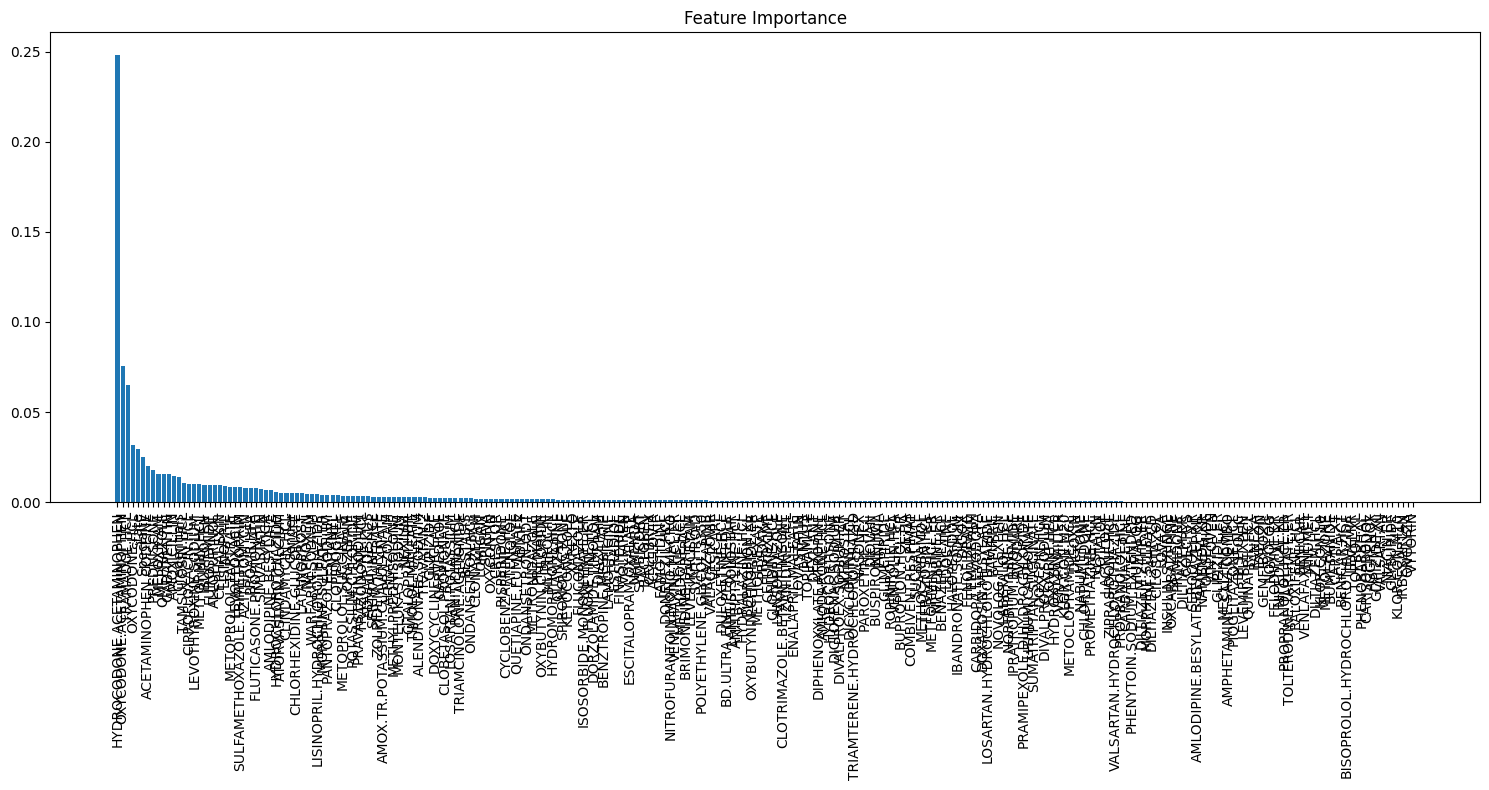

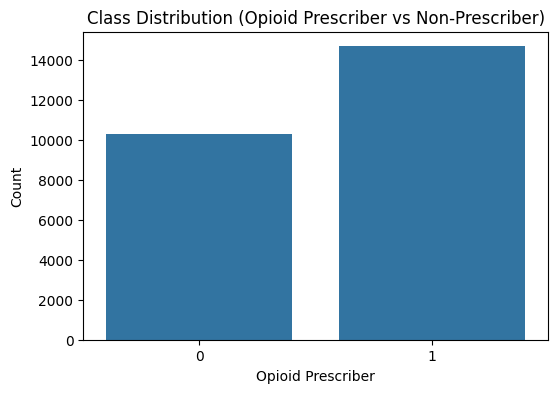

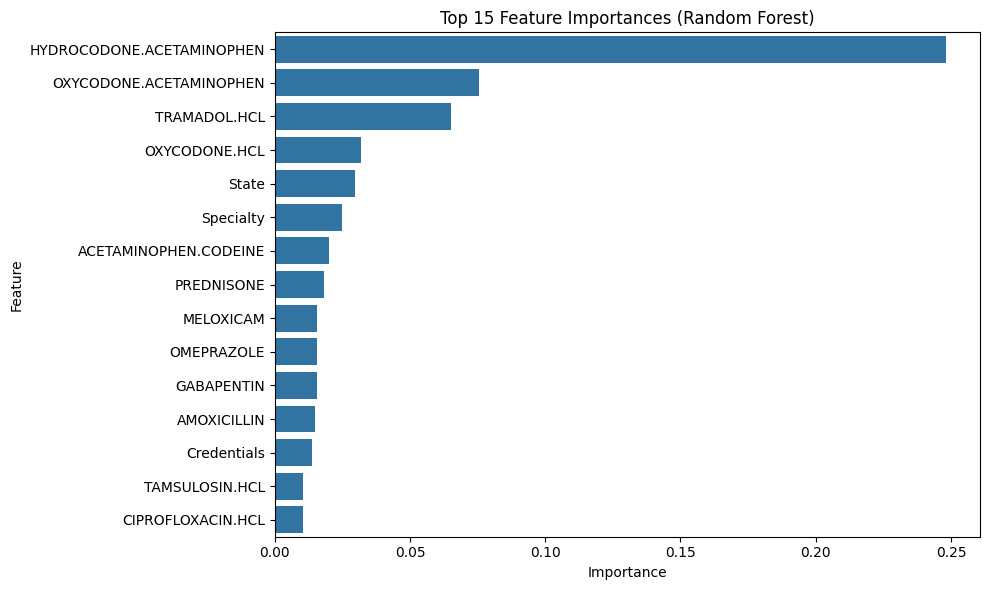

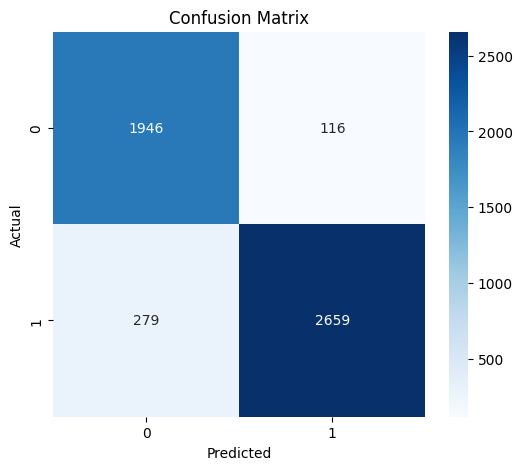

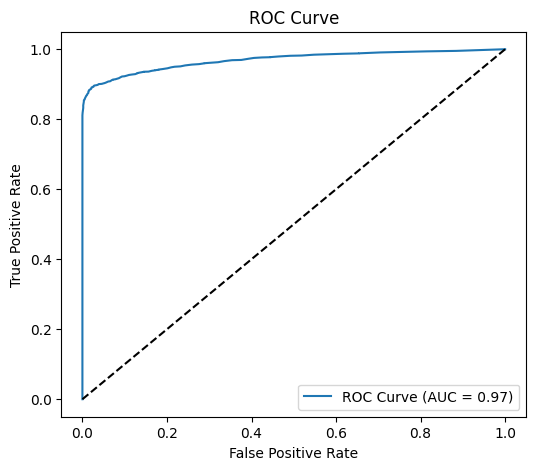

✅ All visualization images saved: class_distribution.png, feature_importance.png, confusion_matrix.png, roc_curve.png


In [36]:
def main():
    """
    Main function to orchestrate the entire machine learning pipeline.
    """
    df, _, _, _ = load_and_analyze_data()
    
    if df is not None:
        df_processed = preprocess_data(df)
        X_train, X_test, y_train, y_test = split_data(df_processed)
        
        if X_train is not None:
            model = train_model(X_train, y_train)
            evaluate_and_save_model(model, X_test, y_test)
            # Uncomment the line below to generate plots after running the pipeline
            visualize_results(model, X_test, y_test, df_processed)

if __name__ == '__main__':
    main()